In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nltk
import keras  # only for loading the dataset and preprocessing
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from gensim.models import word2vec, KeyedVectors
from sklearn.model_selection import train_test_split
import gensim.downloader
import re
from nltk.corpus import stopwords
import time
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/DataSolve/competition/Word2Vec+CNN"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['answer_w2vCNN.csv',
 'output',
 '.ipynb_checkpoints',
 'regulationword2vec_mincount1.model',
 'regulationword2vec_mincount1-300.model',
 'answer_w2vCNNv2.csv',
 'answer_w2vCNNv3.csv',
 'answer_w2vCNNv4.csv',
 'answer_w2vCNNv5.csv',
 'answer_w2vCNNv6.csv',
 'answer_w2vCNNv7.csv',
 'answer_w2vCNNv8.csv',
 'answer_w2vCNNv9.csv',
 'pretrained_data_for_CNN_LSTM.csv',
 'pretrained_test_data_for_CNN_LSTM.csv',
 'answer_w2vCNNv10.csv',
 'answer_w2vCNNv11.csv',
 'answer_w2vCNNv12.csv',
 'answer_w2vLSTMv1.csv',
 'answer_w2vCNNv13.csv',
 'answer_w2vCNNv14.csv',
 'answer_w2vCNNv15.csv',
 'answer_w2vCNNv17.csv',
 'answer_w2vCNNv18.csv',
 'answer_w2vCNNv19.csv',
 'answer_w2vCNNv20.csv',
 'answer_w2vCNNv21.csv',
 'answer_w2vCNNv22.csv',
 'answer_w2vCNNv23.csv',
 'answer_w2vCNNv24.csv',
 'selftrain_w2v+CNN_LSTM.ipynb']

In [ ]:
# import train and test data
df = pd.read_csv('../data/train_final.csv')
df.drop('Unnamed: 0', axis =1, inplace = True)
df['context'] = df['name'] + '. ' + df['document_text']

test_df = pd.read_csv('../data/test.csv')
test_df['context'] = test_df['name'] + '. ' + test_df['document_text']

In [ ]:
df['context'].head()

0    Consent Order in the Matter of Solium Financia...
1    Alberta Securities Commission Warns Investors ...
2    Exempt Market Dealer Agrees to Settlement. The...
3    Canadian Securities Regulators Announces Consu...
4    CSA Consultation Paper 51-405 Consideration of...
Name: context, dtype: object

In [ ]:
# generate target columns
label_cols = [col for col in df.columns if col not in ['id', 'name', 'document_text', 'context']]
label_cols

['Accounting and Finance',
 'Antitrust',
 'Banking',
 'Broker Dealer',
 'Commodities Trading',
 'Compliance Management',
 'Consumer protection',
 'Contract Provisions',
 'Corporate Communications',
 'Corporate Governance',
 'Definitions',
 'Delivery',
 'Examinations',
 'Exemptions',
 'Fees and Charges',
 'Financial Accounting',
 'Financial Crime',
 'Forms',
 'Fraud',
 'IT Risk',
 'Information Filing',
 'Insurance',
 'Legal',
 'Legal Proceedings',
 'Licensing',
 'Licensure and certification',
 'Liquidity Risk',
 'Listing',
 'Market Abuse',
 'Market Risk',
 'Monetary and Economic Policy',
 'Money Services',
 'Money-Laundering and Terrorist Financing',
 'Natural Disasters',
 'Payments and Settlements',
 'Powers and Duties',
 'Quotation',
 'Records Maintenance',
 'Regulatory Actions',
 'Regulatory Reporting',
 'Required Disclosures',
 'Research',
 'Risk Management',
 'Securities Clearing',
 'Securities Issuing',
 'Securities Management',
 'Securities Sales',
 'Securities Settlement',
 'Tra

(array([2959., 1195.,  456.,  215.,   80.,   49.,   22.,   11.,    3.,
           3.]),
 array([  59. ,  181.6,  304.2,  426.8,  549.4,  672. ,  794.6,  917.2,
        1039.8, 1162.4, 1285. ]),
 <a list of 10 Patch objects>)

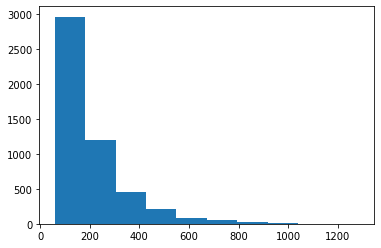

In [ ]:
# find out the distribution of context lengths
from collections import Counter
import matplotlib.pyplot as plt
def bag_of_words(text):
    # TODO: Implement bag of words
    return len(text.split(' '))
plt.hist(test_df['context'].apply(bag_of_words))

In [ ]:
def clean_text(text):
    if text == None:
        return None
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = re.sub('_+', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip(' ')
    
    return text

In [ ]:
def tokenizer(text):
    sentences = nltk.sent_tokenize(text)

    sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

    for i in range(len(sentences)):
        sentences[i] = [word for word in sentences[i] if word not in stopwords.words('english')]
    
    return sentences[0]

In [ ]:
df['context'] = df['context'].map(lambda con: tokenizer(clean_text(con)))
test_df['context'] = test_df['context'].map(lambda con: tokenizer(clean_text(con)))

In [ ]:
word_list = []
for i in df['context']:
    word_list += i

for i in test_df['context']:
    word_list += i

In [ ]:
word_list = pd.Series(word_list).unique()

In [ ]:
len(word_list)

34473

In [ ]:
word_list.sort()

In [ ]:
index = 1 
word_dict = {}
for word in word_list:
    
    word_dict.update({word: index})
    index += 1

In [ ]:
word_dict

In [ ]:
my_word2vec = word2vec.Word2Vec.load('regulationword2vec_mincount1-300.model')

In [ ]:
df['pretrained'] = df['context'].map(lambda li: pd.Series(li).map(lambda word: my_word2vec.wv.index2word.index(word)))

In [ ]:
test_df['pretrained'] = test_df['context'].map(lambda li: pd.Series(li).map(lambda word: my_word2vec.wv.index2word.index(word)))

In [ ]:
df.to_csv('pretrained_data_for_CNN_LSTM.csv', index=False)

In [ ]:
test_df.to_csv('pretrained_test_data_for_CNN_LSTM.csv', index=False)

In [ ]:
# import train and test data
df = pd.read_csv('pretrained_data_for_CNN_LSTM.csv')


test_df = pd.read_csv('pretrained_test_data_for_CNN_LSTM.csv')

In [ ]:
df[''].head()

0    ['consent', 'order', 'matter', 'solium', 'fina...
1    ['alberta', 'securities', 'commission', 'warns...
2    ['exempt', 'market', 'dealer', 'agrees', 'sett...
3    ['canadian', 'securities', 'regulators', 'anno...
4    ['csa', 'consultation', 'paper', 'consideratio...
Name: context, dtype: object

In [ ]:
def w2vpreprocess(sentence_list):
    words_list = []
    for sentence in sentence_list:   
        temp = clean_text(sentence)
        if temp != '':
            words = tokenizer(temp)
            words_list.append(words)

    return words_list


In [ ]:
df['w2v_list'] = df['sentence'].map(lambda x: w2vpreprocess(x))
test_df['w2v_list'] = test_df['sentence'].map(lambda x: w2vpreprocess(x))

In [ ]:
sentences = df['w2v_list'].values.tolist() + test_df['w2v_list'].values.tolist()

In [ ]:
sentences

In [ ]:
ns = []
for item in sentences:
    for i in item:
        ns.append(i)

In [ ]:
start_time = time.time()

my_word2vec = word2vec.Word2Vec(sentences=ns,
                 sg=1, 
                 size=300,
                 window=5,
                 negative=5,
                 min_count=1,
                 iter=100 
              )

print(f'Time taken : {(time.time() - start_time) / 60:.2f} mins')

Time taken : 26.32 mins


In [ ]:
my_word2vec.save('regulationword2vec_mincount1-300.model')

In [ ]:
my_word2vec.wv.vocab

In [ ]:
my_word2vec.wv.index2word

In [ ]:
my_word2vec['exchange']

In [ ]:
my_word2vec.wv.vectors

In [ ]:
wikiw2v = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
from gensim.models import KeyedVectors

In [ ]:
wikiw2v.wv.vocab

In [ ]:
wikiw2v['the']

In [ ]:
wikiw2v.wv.vectors

In [ ]:
train_df, eval_df = train_test_split(df, train_size = 0.9,test_size = 0.1, random_state=42)

In [ ]:
class RegulationDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)
      
    def __getitem__(self, index):        
        data_row = self.dataframe.iloc[index]

        features = data_row['pretrained']
        labels = data_row[label_cols]

        return torch.FloatTensor(features), torch.FloatTensor(labels)


In [ ]:
class RegulationTestDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)
      
    def __getitem__(self, index):        
        data_row = self.dataframe.iloc[index]

        features = data_row['pretrained']

        return torch.FloatTensor(features)

In [ ]:
train_dataset = RegulationDataset(train_df)
eval_dataset = RegulationDataset(eval_df)
test_dataset = RegulationTestDataset(test_df)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import keras  # only for loading the dataset and preprocessing
import keras_preprocessing
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from gensim.models import word2vec
import pandas as pd

In [ ]:
train_df, eval_df = train_test_split(df, train_size = 0.8,test_size = 0.2, random_state=42)

In [ ]:
item

In [ ]:
lens = []
for item in df['pretrained']:
    lens.append(len(item))

In [ ]:
pd.Series(lens).quartiles(0.9)

In [ ]:
DOC_LEN = 384
train_x = keras.utils.pad_sequences(train_df['pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

eval_x = keras.utils.pad_sequences(eval_df['pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

test_x = keras.utils.pad_sequences(test_df['pretrained'],
                                    value=0,
                                    padding='post',
                                    maxlen=DOC_LEN)

print(train_x.shape)
print(eval_x.shape)
print(test_x.shape)

(7887, 384)
(1972, 384)
(4993, 384)


In [ ]:
print(train_x[0])

In [ ]:
class RegulationDataset(Dataset):
    def __init__(self, features, dataframe):
        self.dataframe = dataframe
        self.features = torch.IntTensor(features)

    def __len__(self):
        return len(self.dataframe)
      
    def __getitem__(self, index):        
        data_row = self.dataframe.iloc[index]

        labels = data_row[label_cols]

        return self.features[index], torch.FloatTensor(labels)

In [ ]:
class RegulationTestDataset(Dataset):
    def __init__(self, features):
        self.features = torch.IntTensor(features)

    def __len__(self):
        return len(self.features)
      
    def __getitem__(self, index):        
        return self.features[index]

In [ ]:
# datasets
train_dataset = RegulationDataset(train_x, train_df)

eval_dataset = RegulationDataset(eval_x, eval_df)

test_dataset = RegulationTestDataset(test_x)

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, weights, embedding_dim, out_channels, dropout_ratio):
        super(TextCNN, self).__init__()
        self.weights = weights
        self.embedding_dim = embedding_dim
        self.dropout_ratio = dropout_ratio
        
        # embedding
        self.embedding = nn.Embedding.from_pretrained(self.weights)  # (-1, DOC_LEN, embedding_dim), num_embedding: embedding dict size, embedding_dim: length of embedding vector
        
        # 1D CNN
        # unigram
        self.unigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=2),  # (-1, 64, DOC_LEN)
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 2 + 1),  # (-1, 64, 1)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # bigram
        self.bigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=3),  # (-1, 64, DOC_LEN-2+1) ??? why DOC_LEN - 2 + 1
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 3 + 1),  # (-1, 64, 1)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # trigram
        self.trigram = nn.Sequential(# input (-1, embedding_dim, DOC_LEN)
        nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=4),  # (-1, 64, DOC_LEN-3+1)
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=DOC_LEN - 4 + 1),  # (-1, 16, 7)
        nn.Flatten()  # (-1, 64 * 1)
        )
        # simple classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=out_channels*3, out_features=50)
        )
    def forward(self, x):
        # get embedding
        x = self.embedding(x)
        # make sure we are convolving on each word
        x = torch.transpose(x, dim0=1, dim1=2)  # (-1, DOC_LEN, embedding_dim): embedding on 1(DOC_LEN) & 2(embedding_dim) dims
        # 1d cnn output
        uni_gram_output = self.unigram(x)
        bi_gram_output = self.bigram(x)
        tri_gram_output = self.trigram(x)

        # concatenate
        x = torch.cat((uni_gram_output, bi_gram_output, tri_gram_output), dim=1)
        # classifier
        x = self.classifier(x)

        return x


In [ ]:
weights = torch.FloatTensor(my_word2vec.wv.vectors)

In [ ]:
model=TextCNN(weights,300,1024,0.3)

In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary

In [ ]:
summary(TextCNN(weights,300,1024,0.3))

Layer (type:depth-idx)                   Param #
TextCNN                                  --
├─Embedding: 1-1                         (10,341,900)
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       615,424
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
│    └─Flatten: 2-4                      --
├─Sequential: 1-3                        --
│    └─Conv1d: 2-5                       922,624
│    └─ReLU: 2-6                         --
│    └─MaxPool1d: 2-7                    --
│    └─Flatten: 2-8                      --
├─Sequential: 1-4                        --
│    └─Conv1d: 2-9                       1,229,824
│    └─ReLU: 2-10                        --
│    └─MaxPool1d: 2-11                   --
│    └─Flatten: 2-12                     --
├─Sequential: 1-5                        --
│    └─Dropout: 2-13                     --
│    └─Linear: 2-14                      153,650
Total params: 13,263,422
Trainable para

In [ ]:
def train_model(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size=32):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x)
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item() 
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item() 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.5f}")
    
    return history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.005,
                      epochs=5,
                      batch_size=64)

Training Start
Epoch:1 / 5, train loss:0.2500 train_acc:0.9210, valid loss:0.1589 valid acc:0.94248
Epoch:2 / 5, train loss:0.1362 train_acc:0.9517, valid loss:0.1191 valid acc:0.95538
Epoch:3 / 5, train loss:0.1153 train_acc:0.9586, valid loss:0.1133 valid acc:0.95979
Epoch:4 / 5, train loss:0.1061 train_acc:0.9618, valid loss:0.1055 valid acc:0.96256
Epoch:5 / 5, train loss:0.1014 train_acc:0.9635, valid loss:0.1014 valid acc:0.96360


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0005,
                      epochs=2,
                      batch_size=32)

Training Start
Epoch:1 / 2, train loss:0.0768 train_acc:0.9724, valid loss:0.0872 valid acc:0.96923
Epoch:2 / 2, train loss:0.0679 train_acc:0.9758, valid loss:0.0847 valid acc:0.96947


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00005,
                      epochs=8,
                      batch_size=32)

Training Start
Epoch:1 / 8, train loss:0.0601 train_acc:0.9789, valid loss:0.0837 valid acc:0.97010
Epoch:2 / 8, train loss:0.0593 train_acc:0.9795, valid loss:0.0832 valid acc:0.97012
Epoch:3 / 8, train loss:0.0593 train_acc:0.9794, valid loss:0.0830 valid acc:0.96994
Epoch:4 / 8, train loss:0.0581 train_acc:0.9797, valid loss:0.0826 valid acc:0.97039
Epoch:5 / 8, train loss:0.0577 train_acc:0.9801, valid loss:0.0824 valid acc:0.97054
Epoch:6 / 8, train loss:0.0571 train_acc:0.9803, valid loss:0.0825 valid acc:0.97049


KeyboardInterrupt: ignored

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00001,
                      epochs=2,
                      batch_size=64)

Training Start
Epoch:1 / 2, train loss:0.0561 train_acc:0.9806, valid loss:0.0821 valid acc:0.97057
Epoch:2 / 2, train loss:0.0560 train_acc:0.9807, valid loss:0.0820 valid acc:0.97053


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.000008,
                      epochs=2,
                      batch_size=64)

Training Start
Epoch:1 / 2, train loss:0.0556 train_acc:0.9809, valid loss:0.0820 valid acc:0.97055
Epoch:2 / 2, train loss:0.0562 train_acc:0.9806, valid loss:0.0818 valid acc:0.97067


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00002,
                      epochs=5,
                      batch_size=64)

Training Start
Epoch:1 / 5, train loss:0.0555 train_acc:0.9811, valid loss:0.0820 valid acc:0.97053
Epoch:2 / 5, train loss:0.0556 train_acc:0.9810, valid loss:0.0818 valid acc:0.97071
Epoch:3 / 5, train loss:0.0553 train_acc:0.9811, valid loss:0.0818 valid acc:0.97065
Epoch:4 / 5, train loss:0.0553 train_acc:0.9809, valid loss:0.0818 valid acc:0.97072
Epoch:5 / 5, train loss:0.0547 train_acc:0.9814, valid loss:0.0816 valid acc:0.97077


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00005,
                      epochs=3,
                      batch_size=64)

Training Start
Epoch:1 / 3, train loss:0.0553 train_acc:0.9810, valid loss:0.0815 valid acc:0.97080
Epoch:2 / 3, train loss:0.0551 train_acc:0.9810, valid loss:0.0819 valid acc:0.97043
Epoch:3 / 3, train loss:0.0544 train_acc:0.9814, valid loss:0.0814 valid acc:0.97066


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=3,
                      batch_size=64)

Training Start
Epoch:1 / 3, train loss:0.0512 train_acc:0.9828, valid loss:0.0803 valid acc:0.97129
Epoch:2 / 3, train loss:0.0495 train_acc:0.9837, valid loss:0.0799 valid acc:0.97134
Epoch:3 / 3, train loss:0.0496 train_acc:0.9836, valid loss:0.0795 valid acc:0.97149


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=3,
                      batch_size=64)

Training Start
Epoch:1 / 3, train loss:0.0491 train_acc:0.9839, valid loss:0.0791 valid acc:0.97156
Epoch:2 / 3, train loss:0.0484 train_acc:0.9840, valid loss:0.0792 valid acc:0.97153
Epoch:3 / 3, train loss:0.0475 train_acc:0.9846, valid loss:0.0791 valid acc:0.97158


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=3,
                      batch_size=64)

Training Start
Epoch:1 / 3, train loss:0.0472 train_acc:0.9847, valid loss:0.0787 valid acc:0.97167
Epoch:2 / 3, train loss:0.0461 train_acc:0.9852, valid loss:0.0786 valid acc:0.97181
Epoch:3 / 3, train loss:0.0458 train_acc:0.9851, valid loss:0.0784 valid acc:0.97198


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=3,
                      batch_size=64)

Training Start
Epoch:1 / 3, train loss:0.0428 train_acc:0.9864, valid loss:0.0776 valid acc:0.97195
Epoch:2 / 3, train loss:0.0416 train_acc:0.9871, valid loss:0.0775 valid acc:0.97231
Epoch:3 / 3, train loss:0.0411 train_acc:0.9874, valid loss:0.0776 valid acc:0.97196


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=3,
                      batch_size=64)

Training Start
Epoch:1 / 3, train loss:0.0411 train_acc:0.9873, valid loss:0.0775 valid acc:0.97239
Epoch:2 / 3, train loss:0.0404 train_acc:0.9878, valid loss:0.0768 valid acc:0.97254
Epoch:3 / 3, train loss:0.0396 train_acc:0.9883, valid loss:0.0769 valid acc:0.97286


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=10,
                      batch_size=64)

Training Start
Epoch:1 / 10, train loss:0.0395 train_acc:0.9881, valid loss:0.0766 valid acc:0.97283
Epoch:2 / 10, train loss:0.0387 train_acc:0.9885, valid loss:0.0768 valid acc:0.97246
Epoch:3 / 10, train loss:0.0381 train_acc:0.9889, valid loss:0.0769 valid acc:0.97248
Epoch:4 / 10, train loss:0.0381 train_acc:0.9889, valid loss:0.0762 valid acc:0.97272
Epoch:5 / 10, train loss:0.0377 train_acc:0.9890, valid loss:0.0764 valid acc:0.97311
Epoch:6 / 10, train loss:0.0372 train_acc:0.9892, valid loss:0.0768 valid acc:0.97276
Epoch:7 / 10, train loss:0.0364 train_acc:0.9896, valid loss:0.0761 valid acc:0.97271
Epoch:8 / 10, train loss:0.0364 train_acc:0.9896, valid loss:0.0767 valid acc:0.97267
Epoch:9 / 10, train loss:0.0361 train_acc:0.9897, valid loss:0.0760 valid acc:0.97295
Epoch:10 / 10, train loss:0.0358 train_acc:0.9900, valid loss:0.0759 valid acc:0.97319


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=10,
                      batch_size=64)

Training Start
Epoch:1 / 10, train loss:0.0357 train_acc:0.9900, valid loss:0.0760 valid acc:0.97309
Epoch:2 / 10, train loss:0.0348 train_acc:0.9905, valid loss:0.0763 valid acc:0.97266
Epoch:3 / 10, train loss:0.0347 train_acc:0.9905, valid loss:0.0759 valid acc:0.97287
Epoch:4 / 10, train loss:0.0346 train_acc:0.9904, valid loss:0.0757 valid acc:0.97285
Epoch:5 / 10, train loss:0.0343 train_acc:0.9906, valid loss:0.0759 valid acc:0.97288
Epoch:6 / 10, train loss:0.0338 train_acc:0.9910, valid loss:0.0754 valid acc:0.97320
Epoch:7 / 10, train loss:0.0334 train_acc:0.9910, valid loss:0.0753 valid acc:0.97318
Epoch:8 / 10, train loss:0.0332 train_acc:0.9912, valid loss:0.0754 valid acc:0.97325
Epoch:9 / 10, train loss:0.0328 train_acc:0.9913, valid loss:0.0753 valid acc:0.97326
Epoch:10 / 10, train loss:0.0327 train_acc:0.9915, valid loss:0.0753 valid acc:0.97324


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=10,
                      batch_size=64)

Training Start
Epoch:1 / 10, train loss:0.0330 train_acc:0.9913, valid loss:0.0754 valid acc:0.97311
Epoch:2 / 10, train loss:0.0320 train_acc:0.9918, valid loss:0.0755 valid acc:0.97275
Epoch:3 / 10, train loss:0.0318 train_acc:0.9920, valid loss:0.0748 valid acc:0.97312
Epoch:4 / 10, train loss:0.0318 train_acc:0.9917, valid loss:0.0756 valid acc:0.97323
Epoch:5 / 10, train loss:0.0314 train_acc:0.9919, valid loss:0.0753 valid acc:0.97300
Epoch:6 / 10, train loss:0.0312 train_acc:0.9920, valid loss:0.0752 valid acc:0.97315
Epoch:7 / 10, train loss:0.0313 train_acc:0.9922, valid loss:0.0747 valid acc:0.97362
Epoch:8 / 10, train loss:0.0308 train_acc:0.9923, valid loss:0.0751 valid acc:0.97317
Epoch:9 / 10, train loss:0.0303 train_acc:0.9926, valid loss:0.0749 valid acc:0.97350
Epoch:10 / 10, train loss:0.0304 train_acc:0.9924, valid loss:0.0753 valid acc:0.97341


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=20,
                      batch_size=64)

Training Start
Epoch:1 / 20, train loss:0.0305 train_acc:0.9924, valid loss:0.0755 valid acc:0.97306
Epoch:2 / 20, train loss:0.0305 train_acc:0.9925, valid loss:0.0750 valid acc:0.97323
Epoch:3 / 20, train loss:0.0298 train_acc:0.9927, valid loss:0.0755 valid acc:0.97334
Epoch:4 / 20, train loss:0.0297 train_acc:0.9928, valid loss:0.0761 valid acc:0.97288
Epoch:5 / 20, train loss:0.0297 train_acc:0.9929, valid loss:0.0748 valid acc:0.97348
Epoch:6 / 20, train loss:0.0295 train_acc:0.9929, valid loss:0.0751 valid acc:0.97334
Epoch:7 / 20, train loss:0.0292 train_acc:0.9930, valid loss:0.0750 valid acc:0.97329
Epoch:8 / 20, train loss:0.0293 train_acc:0.9931, valid loss:0.0760 valid acc:0.97296
Epoch:9 / 20, train loss:0.0289 train_acc:0.9931, valid loss:0.0749 valid acc:0.97367
Epoch:10 / 20, train loss:0.0290 train_acc:0.9932, valid loss:0.0758 valid acc:0.97294
Epoch:11 / 20, train loss:0.0287 train_acc:0.9934, valid loss:0.0750 valid acc:0.97341
Epoch:12 / 20, train loss:0.0286 trai

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/DataSolve/competition/Word2Vec+LSTM/output/regulation22.t7')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=20,
                      batch_size=64)

Training Start
Epoch:1 / 20, train loss:0.0276 train_acc:0.9938, valid loss:0.0748 valid acc:0.97359
Epoch:2 / 20, train loss:0.0273 train_acc:0.9940, valid loss:0.0745 valid acc:0.97355
Epoch:3 / 20, train loss:0.0270 train_acc:0.9941, valid loss:0.0749 valid acc:0.97353
Epoch:4 / 20, train loss:0.0272 train_acc:0.9940, valid loss:0.0750 valid acc:0.97353
Epoch:5 / 20, train loss:0.0270 train_acc:0.9940, valid loss:0.0751 valid acc:0.97333
Epoch:6 / 20, train loss:0.0268 train_acc:0.9943, valid loss:0.0749 valid acc:0.97344
Epoch:7 / 20, train loss:0.0268 train_acc:0.9942, valid loss:0.0748 valid acc:0.97337
Epoch:8 / 20, train loss:0.0265 train_acc:0.9942, valid loss:0.0748 valid acc:0.97350
Epoch:9 / 20, train loss:0.0267 train_acc:0.9943, valid loss:0.0751 valid acc:0.97331
Epoch:10 / 20, train loss:0.0266 train_acc:0.9942, valid loss:0.0747 valid acc:0.97354
Epoch:11 / 20, train loss:0.0264 train_acc:0.9944, valid loss:0.0756 valid acc:0.97308
Epoch:12 / 20, train loss:0.0261 trai

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00015,
                      epochs=20,
                      batch_size=64)

Training Start
Epoch:1 / 20, train loss:0.0268 train_acc:0.9942, valid loss:0.0750 valid acc:0.97323
Epoch:2 / 20, train loss:0.0264 train_acc:0.9943, valid loss:0.0747 valid acc:0.97334
Epoch:3 / 20, train loss:0.0261 train_acc:0.9944, valid loss:0.0759 valid acc:0.97306
Epoch:4 / 20, train loss:0.0261 train_acc:0.9944, valid loss:0.0750 valid acc:0.97324
Epoch:5 / 20, train loss:0.0261 train_acc:0.9947, valid loss:0.0747 valid acc:0.97364
Epoch:6 / 20, train loss:0.0259 train_acc:0.9947, valid loss:0.0749 valid acc:0.97346
Epoch:7 / 20, train loss:0.0257 train_acc:0.9948, valid loss:0.0762 valid acc:0.97282
Epoch:8 / 20, train loss:0.0257 train_acc:0.9947, valid loss:0.0749 valid acc:0.97344
Epoch:9 / 20, train loss:0.0255 train_acc:0.9947, valid loss:0.0748 valid acc:0.97355
Epoch:10 / 20, train loss:0.0254 train_acc:0.9948, valid loss:0.0743 valid acc:0.97366
Epoch:11 / 20, train loss:0.0257 train_acc:0.9946, valid loss:0.0750 valid acc:0.97332
Epoch:12 / 20, train loss:0.0255 trai

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=5,
                      batch_size=64)

Training Start
Epoch:1 / 5, train loss:0.0241 train_acc:0.9954, valid loss:0.0752 valid acc:0.97353
Epoch:2 / 5, train loss:0.0240 train_acc:0.9956, valid loss:0.0749 valid acc:0.97339
Epoch:3 / 5, train loss:0.0237 train_acc:0.9956, valid loss:0.0751 valid acc:0.97328
Epoch:4 / 5, train loss:0.0237 train_acc:0.9957, valid loss:0.0743 valid acc:0.97336
Epoch:5 / 5, train loss:0.0237 train_acc:0.9956, valid loss:0.0752 valid acc:0.97346


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00005,
                      epochs=4,
                      batch_size=64)

Training Start
Epoch:1 / 4, train loss:0.0232 train_acc:0.9960, valid loss:0.0747 valid acc:0.97344
Epoch:2 / 4, train loss:0.0227 train_acc:0.9962, valid loss:0.0746 valid acc:0.97365
Epoch:3 / 4, train loss:0.0229 train_acc:0.9962, valid loss:0.0751 valid acc:0.97334
Epoch:4 / 4, train loss:0.0227 train_acc:0.9961, valid loss:0.0745 valid acc:0.97364


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00005,
                      epochs=10,
                      batch_size=64)

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00003,
                      epochs=4,
                      batch_size=64)

Training Start
Epoch:1 / 4, train loss:0.0228 train_acc:0.9962, valid loss:0.0747 valid acc:0.97338
Epoch:2 / 4, train loss:0.0225 train_acc:0.9963, valid loss:0.0746 valid acc:0.97359
Epoch:3 / 4, train loss:0.0228 train_acc:0.9961, valid loss:0.0751 valid acc:0.97345
Epoch:4 / 4, train loss:0.0224 train_acc:0.9962, valid loss:0.0747 valid acc:0.97363


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00001,
                      epochs=10,
                      batch_size=64)

Training Start
Epoch:1 / 10, train loss:0.0223 train_acc:0.9963, valid loss:0.0747 valid acc:0.97343
Epoch:2 / 10, train loss:0.0222 train_acc:0.9965, valid loss:0.0748 valid acc:0.97341
Epoch:3 / 10, train loss:0.0223 train_acc:0.9964, valid loss:0.0748 valid acc:0.97340
Epoch:4 / 10, train loss:0.0223 train_acc:0.9964, valid loss:0.0746 valid acc:0.97346
Epoch:5 / 10, train loss:0.0222 train_acc:0.9964, valid loss:0.0748 valid acc:0.97338
Epoch:6 / 10, train loss:0.0220 train_acc:0.9965, valid loss:0.0749 valid acc:0.97342
Epoch:7 / 10, train loss:0.0222 train_acc:0.9964, valid loss:0.0747 valid acc:0.97361
Epoch:8 / 10, train loss:0.0220 train_acc:0.9966, valid loss:0.0748 valid acc:0.97350
Epoch:9 / 10, train loss:0.0221 train_acc:0.9966, valid loss:0.0745 valid acc:0.97365
Epoch:10 / 10, train loss:0.0223 train_acc:0.9963, valid loss:0.0746 valid acc:0.97353


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/DataSolve/competition/Word2Vec+LSTM/output/regulation23.t7')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00001,
                      epochs=10,
                      batch_size=256)

Training Start
Epoch:1 / 10, train loss:0.0221 train_acc:0.9966, valid loss:0.0746 valid acc:0.97349
Epoch:2 / 10, train loss:0.0222 train_acc:0.9966, valid loss:0.0749 valid acc:0.97340
Epoch:3 / 10, train loss:0.0220 train_acc:0.9966, valid loss:0.0749 valid acc:0.97348
Epoch:4 / 10, train loss:0.0221 train_acc:0.9966, valid loss:0.0752 valid acc:0.97332
Epoch:5 / 10, train loss:0.0221 train_acc:0.9965, valid loss:0.0748 valid acc:0.97341
Epoch:6 / 10, train loss:0.0221 train_acc:0.9965, valid loss:0.0749 valid acc:0.97336
Epoch:7 / 10, train loss:0.0221 train_acc:0.9965, valid loss:0.0749 valid acc:0.97334
Epoch:8 / 10, train loss:0.0221 train_acc:0.9965, valid loss:0.0747 valid acc:0.97340
Epoch:9 / 10, train loss:0.0220 train_acc:0.9966, valid loss:0.0749 valid acc:0.97342
Epoch:10 / 10, train loss:0.0218 train_acc:0.9966, valid loss:0.0746 valid acc:0.97348


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00001,
                      epochs=10,
                      batch_size=256)

Training Start
Epoch:1 / 10, train loss:0.0223 train_acc:0.9966, valid loss:0.0745 valid acc:0.97358
Epoch:2 / 10, train loss:0.0224 train_acc:0.9967, valid loss:0.0748 valid acc:0.97333
Epoch:3 / 10, train loss:0.0233 train_acc:0.9964, valid loss:0.0748 valid acc:0.97350
Epoch:4 / 10, train loss:0.0235 train_acc:0.9963, valid loss:0.0754 valid acc:0.97327
Epoch:5 / 10, train loss:0.0238 train_acc:0.9962, valid loss:0.0753 valid acc:0.97336
Epoch:6 / 10, train loss:0.0241 train_acc:0.9962, valid loss:0.0751 valid acc:0.97341
Epoch:7 / 10, train loss:0.0246 train_acc:0.9961, valid loss:0.0752 valid acc:0.97336
Epoch:8 / 10, train loss:0.0249 train_acc:0.9961, valid loss:0.0756 valid acc:0.97321
Epoch:9 / 10, train loss:0.0254 train_acc:0.9961, valid loss:0.0755 valid acc:0.97328
Epoch:10 / 10, train loss:0.0257 train_acc:0.9958, valid loss:0.0756 valid acc:0.97319


In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.00001,
                      epochs=5,
                      batch_size=64)

Training Start
Epoch:1 / 5, train loss:0.0096 train_acc:0.9983, valid loss:0.0875 valid acc:0.97245
Epoch:2 / 5, train loss:0.0094 train_acc:0.9984, valid loss:0.0872 valid acc:0.97259
Epoch:3 / 5, train loss:0.0094 train_acc:0.9984, valid loss:0.0878 valid acc:0.97254
Epoch:4 / 5, train loss:0.0094 train_acc:0.9984, valid loss:0.0874 valid acc:0.97250
Epoch:5 / 5, train loss:0.0092 train_acc:0.9984, valid loss:0.0875 valid acc:0.97259


In [ ]:
state = { 
        'model': model.state_dict()
        }
save_path="/content/drive/MyDrive/DataSolve/competition/Word2Vec+LSTM/output"   
torch.save(state,save_path+'/regulation24'+".t7"  )

In [ ]:
history = train_model(model=model,
                      train_dataset=train_dataset,
                      test_dataset=eval_dataset,
                      device=device,
                      lr=0.0001,
                      epochs=40,
                      batch_size=256)

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/DataSolve/competition/Word2Vec+LSTM/output/regulation3.t7')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
pred_table = []
test_loader = DataLoader(test_dataset, batch_size=1)
model.to(device)
model.eval()
with torch.no_grad():
    for x in test_loader:
        # move
        x = x.to(device)
        # predict
        outputs = model(x)
        pred = torch.round(torch.sigmoid(outputs))
        pred_table.append(pred)

In [ ]:
pred_df = []
def to_a(t):
    return t.cpu().detach().numpy().reshape(50)
for t in pred_table:
    pred_df.append(to_a(t))

test_pred = pd.DataFrame(pred_df)
test_pred.columns = label_cols
test_pred = test_pred.astype('int')
test_final = pd.concat([test_df,test_pred], axis=1)

In [ ]:
id_table = []
for i in test_final['id']:
    for target in label_cols:
        id_table.append(str(i)+'_'+target)
        
prediction_table = []
for col, row in test_final.iterrows():
    for target in label_cols:
        prediction_table.append(row[target])

In [ ]:
answer = pd.concat([pd.DataFrame(id_table), pd.DataFrame(prediction_table)], axis =1)
answer.columns = ['id', 'predictions']
answer.to_csv('answer_w2vCNNv24.csv', header=True, index=False)
answer

,id,predictions
0,4771_Accounting and Finance,1
1,4771_Antitrust,0
2,4771_Banking,0
3,4771_Broker Dealer,0
4,4771_Commodities Trading,0
...,...,...
249645,57235_Securities Management,0
249646,57235_Securities Sales,0
249647,57235_Securities Settlement,0
249648,57235_Trade Pricing,0
